In [1]:
from components import *
import modular_network
import mnist_loader, fashion_mnist_loader
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sci

In [2]:
mnist_train, mnist_val, mnist_test = mnist_loader.load_data_wrapper("../data/mnist.pkl.gz")

In [10]:
n_train = len(mnist_train)
reg = L2Regularization(3.125 / n_train)

net = modular_network.Network([
    Flatten((28, 28)),
    FullyConnected(28*28, 100, tanh(), reg),
    FullyConnected(100, 100, tanh(), reg),
    FullyConnected(100, 10, Softmax(), reg)
], cost=BinaryCrossEntropyCost())

aug = RandUniformAug(-0.2, 0.2)

#optim = SGD_momentum_optimizer(0.005, 20, 0.95)
optim = RMSProp_optimizer(0.005, 20, 0.99)
optim_2 = RMSProp_optimizer(0.001, 20, 0.99)

In [11]:
net.set_optimizer(optim)
net.SGD(mnist_train, 10, 20, mnist_val, data_augmentation = aug,
        monitor_test_acc = True, monitor_training_acc = False)


Epoch 1 training complete, took 9.037020683288574 seconds
Accuracy on test data: 9373 / 10000
Epoch 2 training complete, took 10.418551683425903 seconds
Accuracy on test data: 9532 / 10000
Epoch 3 training complete, took 11.626615285873413 seconds
Accuracy on test data: 9613 / 10000
Epoch 4 training complete, took 9.900320291519165 seconds
Accuracy on test data: 9682 / 10000
Epoch 5 training complete, took 9.888189315795898 seconds
Accuracy on test data: 9707 / 10000
Epoch 6 training complete, took 9.747457504272461 seconds
Accuracy on test data: 9735 / 10000
Epoch 7 training complete, took 9.899268865585327 seconds
Accuracy on test data: 9748 / 10000
Epoch 8 training complete, took 9.750026226043701 seconds
Accuracy on test data: 9755 / 10000
Epoch 9 training complete, took 10.132308959960938 seconds
Accuracy on test data: 9729 / 10000
Epoch 10 training complete, took 9.686205387115479 seconds
Accuracy on test data: 9779 / 10000


In [15]:
adam_net = modular_network.Network([
    Flatten((28, 28)),
    FullyConnected(28*28, 100, tanh(), reg),
    FullyConnected(100, 100, tanh(), reg),
    FullyConnected(100, 10, Softmax(), reg)
], cost=BinaryCrossEntropyCost())

adam_opt = Adam_optimizer(0.005, 20, 0.9, 0.999)

In [16]:
adam_net.set_optimizer(adam_opt)
adam_net.SGD(mnist_train, 10, 20, mnist_val, data_augmentation = aug,
        monitor_test_acc = True, monitor_training_acc = False)


Epoch 1 training complete, took 8.58651065826416 seconds
Accuracy on test data: 9368 / 10000
Epoch 2 training complete, took 10.40066146850586 seconds
Accuracy on test data: 9555 / 10000
Epoch 3 training complete, took 10.95917010307312 seconds
Accuracy on test data: 9634 / 10000
Epoch 4 training complete, took 9.995886087417603 seconds
Accuracy on test data: 9658 / 10000
Epoch 5 training complete, took 9.951453447341919 seconds
Accuracy on test data: 9706 / 10000
Epoch 6 training complete, took 10.865097284317017 seconds
Accuracy on test data: 9737 / 10000
Epoch 7 training complete, took 10.086125373840332 seconds
Accuracy on test data: 9745 / 10000
Epoch 8 training complete, took 10.128782510757446 seconds
Accuracy on test data: 9756 / 10000
Epoch 9 training complete, took 10.007886171340942 seconds
Accuracy on test data: 9772 / 10000
Epoch 10 training complete, took 9.682408571243286 seconds
Accuracy on test data: 9756 / 10000


In [17]:
def backprop_return(net, delta):
    for layer in reversed(net.layers):
        delta = layer.backprop(delta)
    return delta

def get_delta(net, image, Y):
    a_L = net.feedforward(np.array([image]))
    # unscaled delta^L
    delta = net.cost.derivative(a_L, Y)
    # backprop
    return backprop_return(net, delta)[0]


In [18]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def relu(x):
    return np.max([x, np.zeros(x.shape)], axis=0)

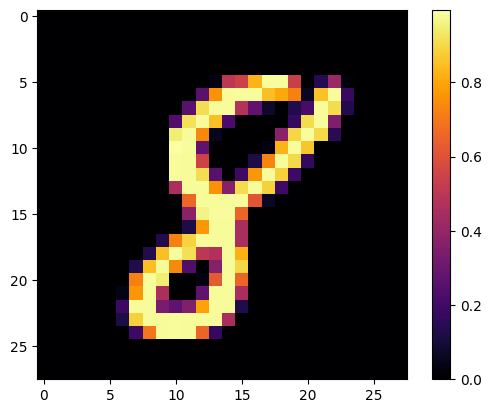

In [23]:
test_image = np.copy(mnist_train[3][0])
plt.imshow(test_image)
plt.set_cmap("inferno")
plt.colorbar()

In [24]:
net.set_mode(Mode.TEST)

In [25]:
net.feedforward(np.array([test_image]))

array([[6.18526407e-08],
       [5.13367478e-08],
       [2.11095061e-06],
       [3.60236833e-06],
       [9.30324945e-07],
       [3.35732669e-07],
       [3.33827245e-08],
       [1.34031689e-08],
       [9.99991912e-01],
       [9.48934135e-07]])

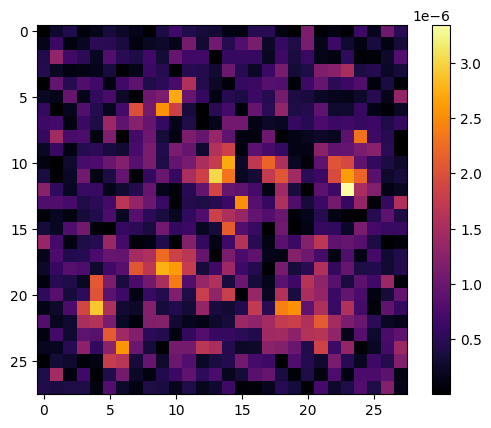

In [26]:
desired_updates = -get_delta(net, test_image, vectorized_result(8))
plt.imshow(np.abs(desired_updates))
plt.colorbar()

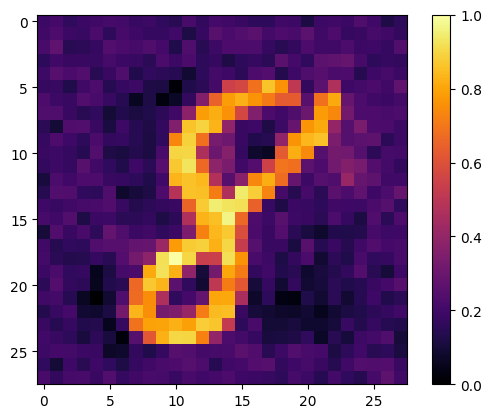

In [30]:
plt.imshow(normalize(test_image + 100000 * desired_updates))
plt.colorbar()

In [32]:
net.feedforward(np.array([normalize(test_image + 10000 * desired_updates)]))

array([[4.62758926e-08],
       [2.26230315e-08],
       [1.90369564e-06],
       [2.52883522e-06],
       [5.70289260e-07],
       [1.86967869e-07],
       [2.52885930e-08],
       [9.32540899e-09],
       [9.99994204e-01],
       [5.02690706e-07]])

In [33]:
def update_test_image(image, Y, update_rate = 1):
    desired_updates = -get_delta(net, image, Y)
    return image + update_rate * desired_updates

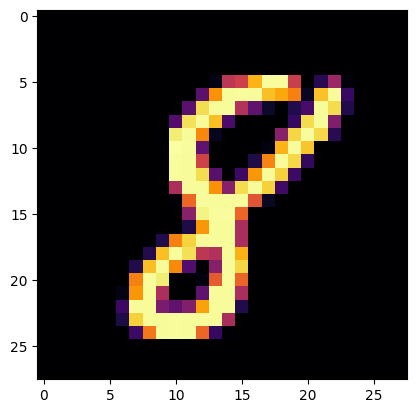

In [100]:
strengthened_image = test_image
plt.imshow(strengthened_image)

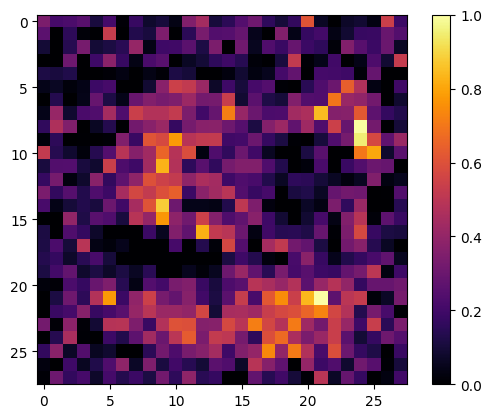

In [122]:
target_num = 5
initial_upd_rate = 0.1
final_upd_rate = 1000
for i in range(1000):
    strengthened_image = update_test_image(strengthened_image, vectorized_result(target_num), update_rate = initial_upd_rate)
    strengthened_image = relu(strengthened_image)
for i in range(1000):
    strengthened_image = update_test_image(strengthened_image, vectorized_result(target_num), update_rate = final_upd_rate)
    strengthened_image = relu(strengthened_image)
strengthened_image = normalize(strengthened_image)
plt.imshow(strengthened_image)
plt.colorbar()

In [123]:
net.feedforward(np.array([strengthened_image]))

array([[1.75653706e-08],
       [3.47173677e-08],
       [2.51821412e-10],
       [7.30429839e-07],
       [2.28679936e-09],
       [9.99998284e-01],
       [3.09659640e-07],
       [1.03111242e-09],
       [2.47374905e-07],
       [3.73157150e-07]])

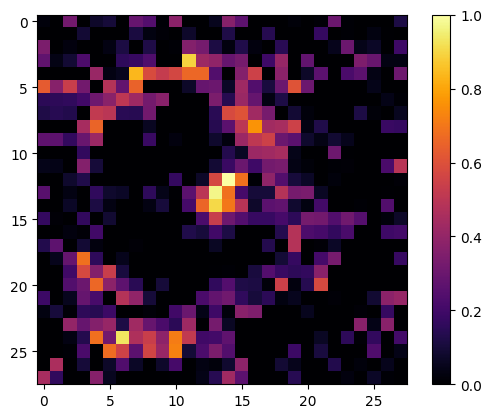

In [154]:
random_image = 0.00 * np.random.randn(28, 28)
dreamed_image = random_image

target_num = 3
initial_upd_rate = 0.1
final_upd_rate = 1000

for i in range(1000):
    dreamed_image = update_test_image(dreamed_image, vectorized_result(target_num), update_rate = initial_upd_rate)
    dreamed_image = relu(dreamed_image)
for i in range(1000):
    dreamed_image = update_test_image(dreamed_image, vectorized_result(target_num), update_rate = final_upd_rate)
    dreamed_image = relu(dreamed_image)
dreamed_image = normalize(dreamed_image)
plt.set_cmap("inferno")
plt.imshow(dreamed_image)
plt.colorbar()

In [155]:
net.feedforward(np.array([random_image]))

array([[1.84731065e-04],
       [1.29784822e-02],
       [2.29321169e-03],
       [2.18401438e-02],
       [1.67646830e-04],
       [9.09306469e-01],
       [3.26755576e-04],
       [4.88813286e-02],
       [3.42635591e-05],
       [3.98696728e-03]])

In [156]:
net.feedforward(np.array([dreamed_image]))

array([[4.12238855e-10],
       [6.41080938e-09],
       [4.73775026e-08],
       [9.99999675e-01],
       [1.74596292e-10],
       [1.40434899e-07],
       [9.44629705e-12],
       [6.96165989e-09],
       [4.70224210e-08],
       [7.64429631e-08]])

In [207]:
n_train = len(mnist_train)
reg = L2Regularization(3.125 / n_train)

conv_net = modular_network.Network([
    Convolution((28, 28), (5, 5), 4, tanh(), correct2Dinput=True),
    MaxPool((8, 24, 24)),
    Convolution((8, 12, 12), (3, 3), 4, tanh()),
    MaxPool((4, 10, 10)),
    Flatten((4, 5, 5)),
    FullyConnected(4*5*5, 30, tanh(), reg),
    FullyConnected(30, 30, tanh(), reg),
    FullyConnected(30, 10, Softmax(), reg)
], cost=BinaryCrossEntropyCost())

aug = RandUniformAug(-0.2, 0.2)

#optim = SGD_momentum_optimizer(0.005, 20, 0.95)
optim = RMSProp_optimizer(0.005, 20, 0.99)
optim_2 = RMSProp_optimizer(0.001, 20, 0.99)

In [209]:
conv_net.set_optimizer(optim)
conv_net.SGD(mnist_train, 30, 20, mnist_val, data_augmentation = aug,
        monitor_test_acc = True, monitor_training_acc = False)

Epoch 1 training complete, took 1182.0038776397705 seconds
Accuracy on test data: 8855 / 10000


KeyboardInterrupt: 